# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

In [2]:
tf.__version__

'2.7.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cp-r "drive/MyDrive/dataset/data"

cp: missing destination file operand after 'drive/MyDrive/dataset/data'
Try 'cp --help' for more information.


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [5]:
# Run this cell to load the dataset 
train = loadmat('data/data/train_32x32.mat') 
test = loadmat('data/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [6]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [7]:
trainX = train['X']
trainy = train['y']
testX = test['X']
testy = test['y']
trainX.shape

(32, 32, 3, 73257)

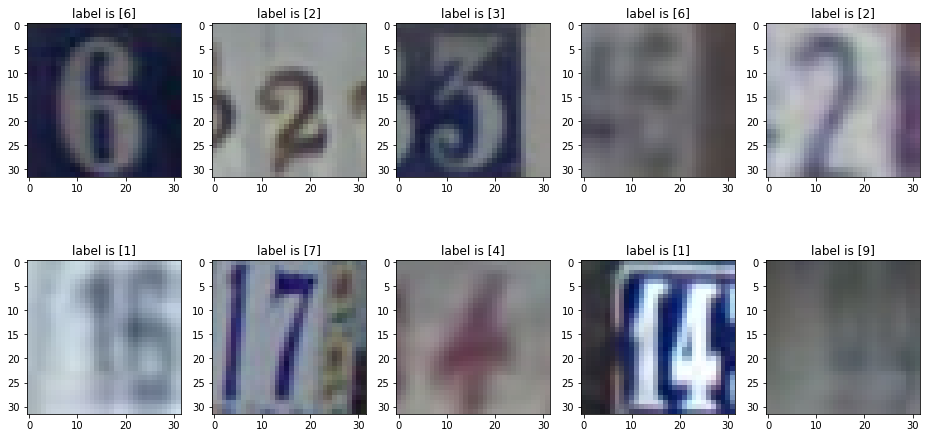

In [8]:
num_train_images = trainX.shape[-1]
random_inx = np.random.choice(num_train_images, 10)

random_train_images = trainX[..., random_inx[0]]

fig, axes = plt.subplots(2, 5, figsize=(16, 8))
count = 0
for i in range(2):
  for j in range(5):
    axes[i, j].set_title(f"label is {trainy[random_inx[count]]}")
    axes[i, j].imshow(trainX[..., random_inx[count]])
    count+=1


plt.show()

In [9]:
trainy.shape

(73257, 1)

In [10]:
trainX.shape[-1]

73257

In [11]:
trainX[...,0].shape

(32, 32, 3)

In [12]:
trainy.reshape(-1, 1).shape

(73257, 1)

In [13]:
# move sample dimesion to start and mean all the channels
trainX = np.moveaxis(trainX, -1, 0)
trainX = np.average(trainX, axis=-1)/255.0

testX = np.moveaxis(testX, -1, 0)
testX = np.average(testX, axis=-1)/255.0

In [14]:
#add channel dimension
trainX = trainX[..., np.newaxis]
testX = testX[..., np.newaxis]
testX.shape

(26032, 32, 32, 1)

[24794 60439 57625 22472 49475 26938  3883 55175 55295 18046]


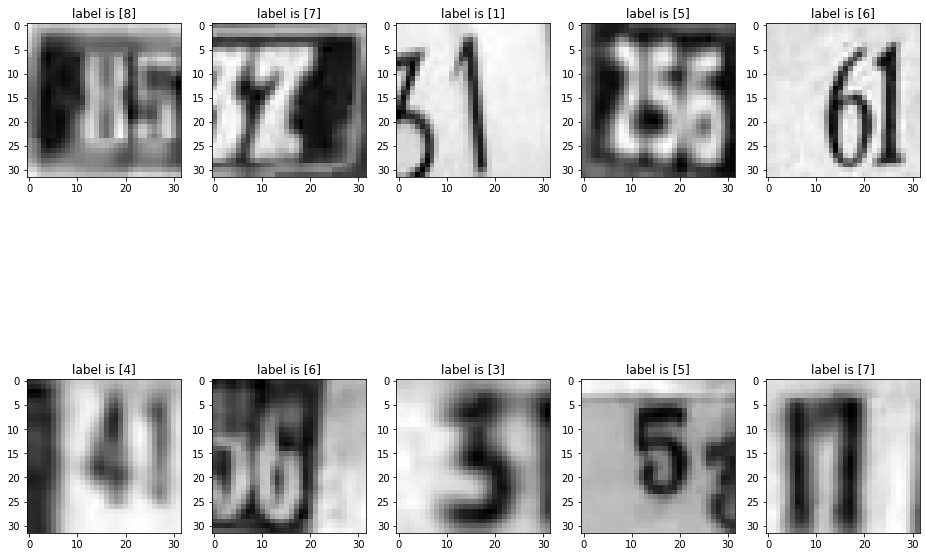

In [15]:
num_train_images = trainX.shape[0]
random_inx = np.random.choice(num_train_images, 10)

print(random_inx)
fig, axes = plt.subplots(2, 5, figsize=(16, 12))
count = 0
for i in range(2):
  for j in range(5):
    axes[i, j].set_title(f"label is {trainy[random_inx[count]]}")
    axes[i, j].imshow(trainX[random_inx[count]].squeeze(), cmap='gray')
    count+=1


plt.show()

In [16]:
testX.shape

(26032, 32, 32, 1)

In [17]:
trainX.shape

(73257, 32, 32, 1)

In [18]:
import numpy as np
nb_classes = 10
data = trainy

def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    print(targets)
    return np.eye(nb_classes)[targets]

In [19]:
train_targets = tf.keras.utils.to_categorical(np.array(trainy-1))
test_targets =  tf.keras.utils.to_categorical(np.array(testy-1))

In [20]:
test_targets.shape


(26032, 10)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [21]:
def get_model(input_shape):
    model = Sequential([
      Flatten(name="flatten", data_format = "channels_first", input_shape = input_shape),
       #Dense(units=1024, activation="relu", name = "dense_1"),
       #Dense(units=512, activation="relu", name = "dense_2"),
       Dense(units=256, activation="relu", name = "dense_3"),
       Dense(units=64, activation="relu", name = "dense_4"),
       Dense(units=32, activation="relu", name = "dense_5"),
        Dense(units=10, activation="softmax", name="dense_6")
        #Flatten()
    ])

    model.compile(optimizer = "adam", 
                  loss = tf.keras.losses.categorical_crossentropy,
                  metrics = ["accuracy"]
                 )
    return model

In [22]:
def scheduler(epoch, lr):
   if epoch < 12:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

#callback = None #tf.keras.callbacks.LearningRateScheduler(scheduler)


In [23]:
checkpoint_path_best = "checkpoint_best"
checkpoint = ModelCheckpoint(filepath = checkpoint_path_best,
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch',
                                monitor = 'val_loss',
                                verbose = 1)

early_stopping = EarlyStopping(monitor = 'val_loss',
                                  patience=2, verbose=1)
callbacks = [checkpoint, early_stopping]

In [24]:

model = get_model(trainX[0].shape)
model.build(trainX[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                                 
Total params: 281,258
Trainable params: 281,258
Non-trainable params: 0
_________________________________________________________________


In [25]:
trainX[0].shape

(32, 32, 1)

In [26]:
#trainy.squeeze().squeeze()
##trainX = tf.cast(
#    trainX, np.float32, name=None
#)
#trainX[0]

In [27]:
test_targets.shape

(26032, 10)

In [28]:
history = model.fit(trainX, train_targets, validation_split=0.15, callbacks = callbacks, epochs=30, batch_size=32)

Epoch 1/30
1941/1946 [============================>.] - ETA: 0s - loss: 2.1703 - accuracy: 0.2139
Epoch 00001: val_loss improved from inf to 2.01797, saving model to checkpoint_best
1946/1946 [==============================] - 17s 8ms/step - loss: 2.1698 - accuracy: 0.2141 - val_loss: 2.0180 - val_accuracy: 0.2835
Epoch 2/30
1936/1946 [============================>.] - ETA: 0s - loss: 1.7571 - accuracy: 0.3904
Epoch 00002: val_loss improved from 2.01797 to 1.55330, saving model to checkpoint_best
1946/1946 [==============================] - 10s 5ms/step - loss: 1.7562 - accuracy: 0.3908 - val_loss: 1.5533 - val_accuracy: 0.4786
Epoch 3/30
1939/1946 [============================>.] - ETA: 0s - loss: 1.4206 - accuracy: 0.5304
Epoch 00003: val_loss improved from 1.55330 to 1.33006, saving model to checkpoint_best
1946/1946 [==============================] - 10s 5ms/step - loss: 1.4203 - accuracy: 0.5306 - val_loss: 1.3301 - val_accuracy: 0.5797
Epoch 4/30
1944/1946 [======================

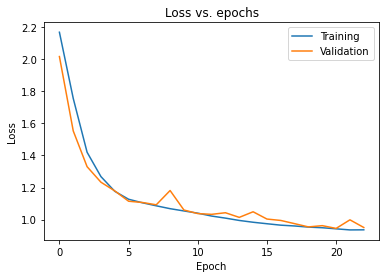

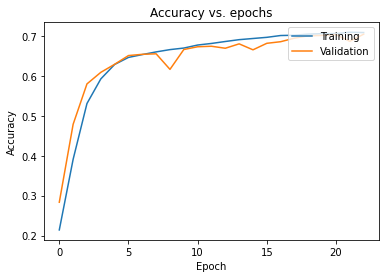

In [29]:
#loss and accuracy curves
# Plot the training and validation loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [35]:
def get_model(input_shape):
    model = Sequential([
       Conv2D(filters = 10, kernel_size=(3,3), kernel_initializer='glorot_uniform', input_shape = input_shape, activation="relu", name = "CONV_1"),
       BatchNormalization(),
       Conv2D(filters = 5, kernel_size=(3,3), kernel_initializer='glorot_uniform', activation="relu", name = "CONV_2"),
       BatchNormalization(),
       MaxPooling2D(pool_size=(2, 2)),
       Conv2D(filters = 3, kernel_size=(3,3), activation="relu"),
       Dropout(0.2),
        Flatten(),
       Dense(units=32, activation="relu", name = "dense_1"),
        Dense(units=10, activation="relu", name="dense_2"),
        Dense(units=10, activation="softmax", name="dense_3")
        #Flatten()
    ])

    model.compile(optimizer = "adam", 
                  loss = tf.keras.losses.categorical_crossentropy,
                  metrics = ["accuracy"]
                 )
    return model

In [36]:
checkpoint_path_best_CNN = "checkpoint_best"
checkpoint_CNN = ModelCheckpoint(filepath = checkpoint_path_best_CNN,
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch',
                                monitor = 'val_loss',
                                verbose = 1)

early_stopping = EarlyStopping(monitor = 'val_loss',
                                  patience=3, verbose=1)
callbacks = [checkpoint, early_stopping]

In [37]:

model_cnn = get_model(trainX[0].shape)
model_cnn.build(trainX[0].shape)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv2D)             (None, 30, 30, 10)        100       
                                                                 
 batch_normalization_2 (Batc  (None, 30, 30, 10)       40        
 hNormalization)                                                 
                                                                 
 CONV_2 (Conv2D)             (None, 28, 28, 5)         455       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 5)        20        
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 5)        0         
 2D)                                                             
                                                      

In [38]:
history_cnn = model_cnn.fit(trainX, train_targets, validation_split=0.15, callbacks = callbacks, epochs=30, batch_size=32)

Epoch 1/30
1946/1946 [==============================] - ETA: 0s - loss: 1.2368 - accuracy: 0.5911
Epoch 00001: val_loss did not improve from 0.94447
1946/1946 [==============================] - 17s 8ms/step - loss: 1.2368 - accuracy: 0.5911 - val_loss: 0.9680 - val_accuracy: 0.6911
Epoch 2/30
1941/1946 [============================>.] - ETA: 0s - loss: 0.7617 - accuracy: 0.7624
Epoch 00002: val_loss improved from 0.94447 to 0.71855, saving model to checkpoint_best
1946/1946 [==============================] - 15s 8ms/step - loss: 0.7616 - accuracy: 0.7625 - val_loss: 0.7186 - val_accuracy: 0.7780
Epoch 3/30
1945/1946 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.7899
Epoch 00003: val_loss improved from 0.71855 to 0.67992, saving model to checkpoint_best
1946/1946 [==============================] - 16s 8ms/step - loss: 0.6748 - accuracy: 0.7899 - val_loss: 0.6799 - val_accuracy: 0.7934
Epoch 4/30
1944/1946 [============================>.] - ETA: 0s - loss: 0.632

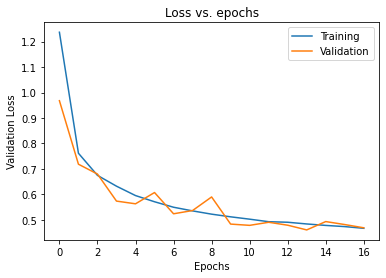

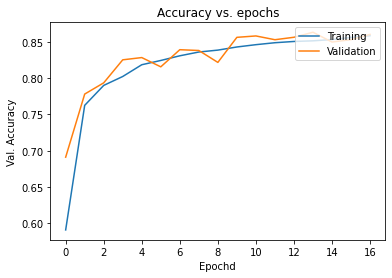

In [39]:
#loss and accuracy curves
# Plot the training and validation loss and accuracy

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Validation Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Val. Accuracy')
plt.xlabel('Epochd')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

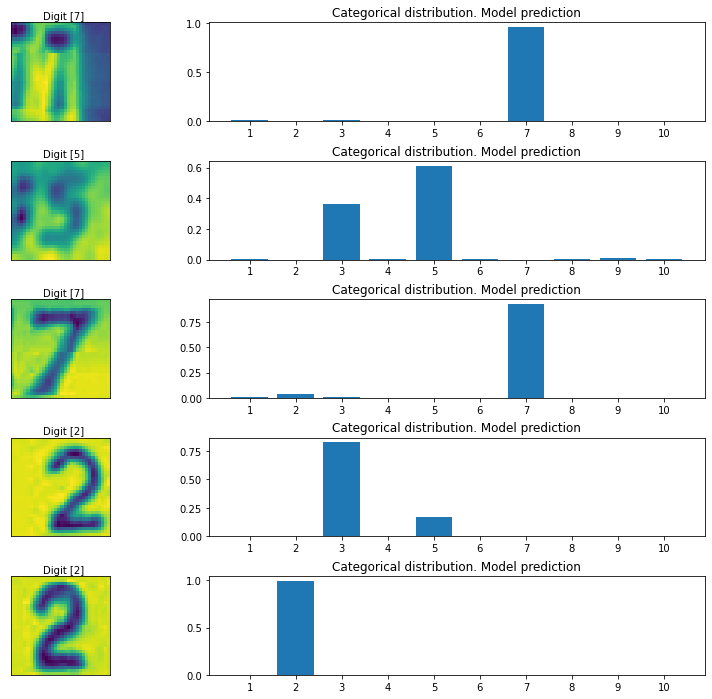

In [40]:
#MLP model predictions
num_test_images = testX.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = testX[random_inx, ...]
random_test_labels = testy[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

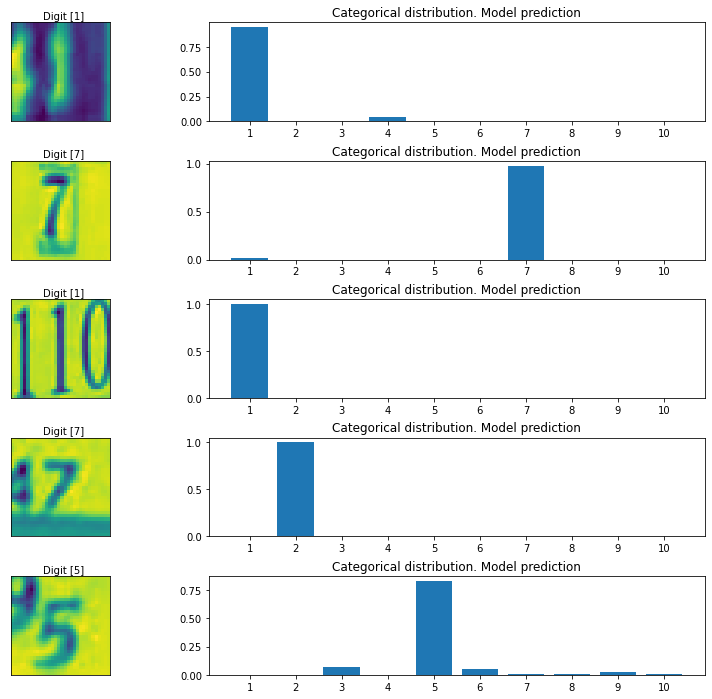

In [41]:
#CNN model's predictins
num_test_images = testX.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = testX[random_inx, ...]
random_test_labels = testy[random_inx, ...]

predictions = model_cnn.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()